In [63]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')

import os
import pandas as pd
import numpy as np
import data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import metrics
import sklearn
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import scipy.stats
import xgboost
import optuna

os.environ.setdefault("TOKENIZERS_PARALLELISM", "true")

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
data = data_utils.load_data()


In [65]:
data.head()

,system,seg_id,source,target,mqm_avg_score,da_score,ref_A,ref_A_mqm_score,ref_B,ref_B_mqm_score,ref_P,ref_P_mqm_score
0,eTranslation.737,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.333333,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
1,Huoshan_Translate.832,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
2,Online-A.1574,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,96.333333,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
3,Online-B.1590,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
4,OPPO.1535,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333


In [66]:
candidates = data.target.tolist()
references = data[['ref_A', 'ref_B', 'ref_P']].to_numpy().tolist()

In [67]:
# Remove references with mqm score <= -1 (equivalent to one minor error)
idxs_filt = []
candidates_filt = []
references_filt = []
for idx, row in data.iterrows():
    refs = []
    for human in "A", "B", "P":
        if row[f"ref_{human}_mqm_score"] > -1:
            refs.append(row[f"ref_{human}"])
    if refs:
        references_filt.append(refs)
        candidates_filt.append(row["target"])
        idxs_filt.append(idx)

data_filt = data.iloc[idxs_filt]


In [68]:
m = metrics.evaluate_all(candidates, references, batch_size=1)
m.head()


,bleu,chrf,rouge,ter,meteor,moverscore,bertscore,baryscore
0,0.452677,71.395594,0.733333,42.0,0.645236,0.689006,0.931161,0.262899
1,0.452274,62.405260,0.562500,60.0,0.535343,0.625638,0.910244,0.305000
2,0.452274,67.662048,0.645161,54.0,0.603856,0.676823,0.928487,0.221799
3,0.452274,59.576021,0.562500,60.0,0.535343,0.617522,0.909932,0.309876
4,0.452274,62.405260,0.562500,60.0,0.535343,0.625638,0.910244,0.305000


In [69]:
m_filt = metrics.evaluate_all(candidates_filt, references_filt, batch_size=1)
m_filt.set_index(np.array(idxs_filt), inplace=True)
m_filt.rename(lambda col: f"{col}_filt", axis=1, inplace=True)
m_filt.head()


,bleu_filt,chrf_filt,rouge_filt,ter_filt,meteor_filt,moverscore_filt,bertscore_filt,baryscore_filt
0,0.452677,71.395594,0.733333,43.75,0.645236,0.689015,0.931161,0.262899
1,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000
2,0.452274,67.662048,0.645161,56.25,0.603856,0.677926,0.928487,0.221799
3,0.443972,59.576021,0.562500,62.50,0.535343,0.618497,0.909932,0.309876
4,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000


In [70]:
full_data = pd.concat([data, m, m_filt], axis=1)
full_data.head()

,system,seg_id,source,target,mqm_avg_score,da_score,ref_A,ref_A_mqm_score,ref_B,ref_B_mqm_score,...,bertscore,baryscore,bleu_filt,chrf_filt,rouge_filt,ter_filt,meteor_filt,moverscore_filt,bertscore_filt,baryscore_filt
0,eTranslation.737,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.333333,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.931161,0.262899,0.452677,71.395594,0.733333,43.75,0.645236,0.689015,0.931161,0.262899
1,Huoshan_Translate.832,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.910244,0.305000,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000
2,Online-A.1574,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,96.333333,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.928487,0.221799,0.452274,67.662048,0.645161,56.25,0.603856,0.677926,0.928487,0.221799
3,Online-B.1590,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.909932,0.309876,0.443972,59.576021,0.562500,62.50,0.535343,0.618497,0.909932,0.309876
4,OPPO.1535,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.910244,0.305000,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000


### Correlation matrices

In [71]:
full_metrics = pd.concat([m, m_filt], axis=1)

filt_columns = list(full_metrics.columns[-8:])
normal_columns = list(full_metrics.columns[:-8])

In [72]:
sns.set_theme(style="white")
corr_mat = np.abs(full_metrics.corr())
mask = np.triu(np.ones_like(corr_mat.loc[normal_columns, normal_columns], dtype=bool))

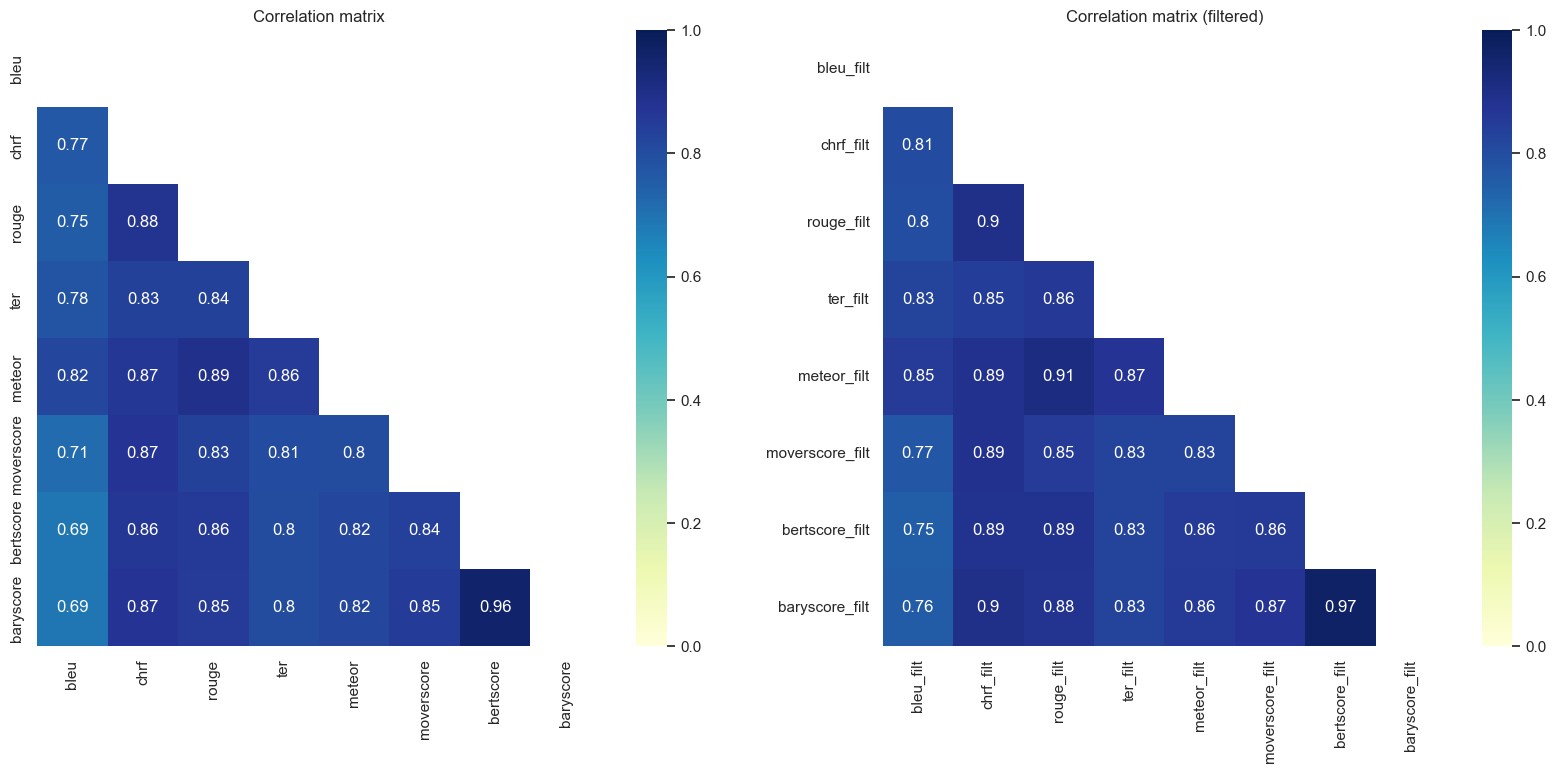

In [73]:
plt.figure(figsize=(20, 8))
plt.subplot(121)

plt.title("Correlation matrix")
g = sns.heatmap(corr_mat.loc[normal_columns, normal_columns], mask=mask, cmap="YlGnBu", vmin=0, vmax=1, annot=True)

plt.subplot(122)
plt.title("Correlation matrix (filtered)")
g = sns.heatmap(corr_mat.loc[filt_columns, filt_columns], mask=mask, cmap="YlGnBu", vmin=0, vmax=1, annot=True)

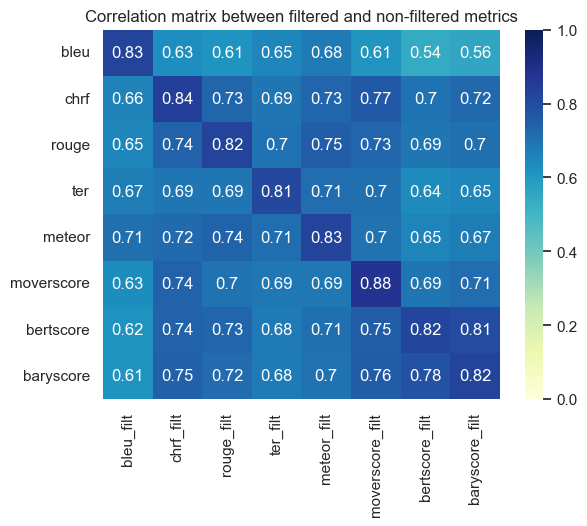

In [74]:
plt.title("Correlation matrix between filtered and non-filtered metrics")
g = sns.heatmap(corr_mat.loc[normal_columns, filt_columns], cmap="YlGnBu", vmin=0, vmax=1, annot=True)

#### Clustering

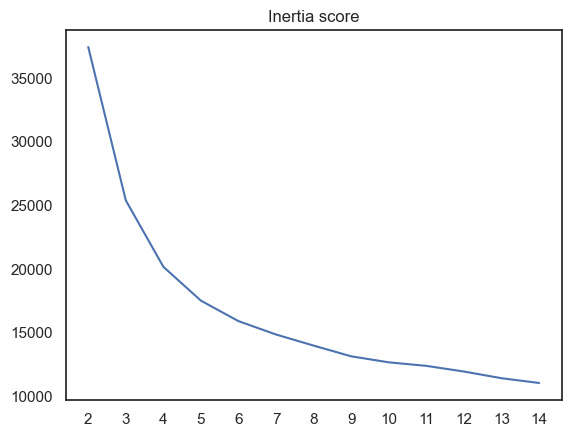

In [75]:
scaled_data = sklearn.preprocessing.StandardScaler().fit_transform(full_metrics.loc[:, normal_columns])

inertia_score = []
total_clusters = 15
for n_clusters in range(2, total_clusters):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    kmeans.fit(scaled_data)
    inertia_score.append(kmeans.inertia_)
    
plt.title("Inertia score")
plt.xticks(range(2, total_clusters))
plt.plot(range(2, total_clusters), inertia_score)

In [76]:
kmeans = sklearn.cluster.KMeans(n_clusters=8, n_init='auto', random_state=42)
kmeans.fit(scaled_data)

pca = sklearn.decomposition.PCA(n_components=2)
decomposed_data = pca.fit_transform(scaled_data)
pca.explained_variance_ratio_

array([0.84593825, 0.05385191])

<Axes: >

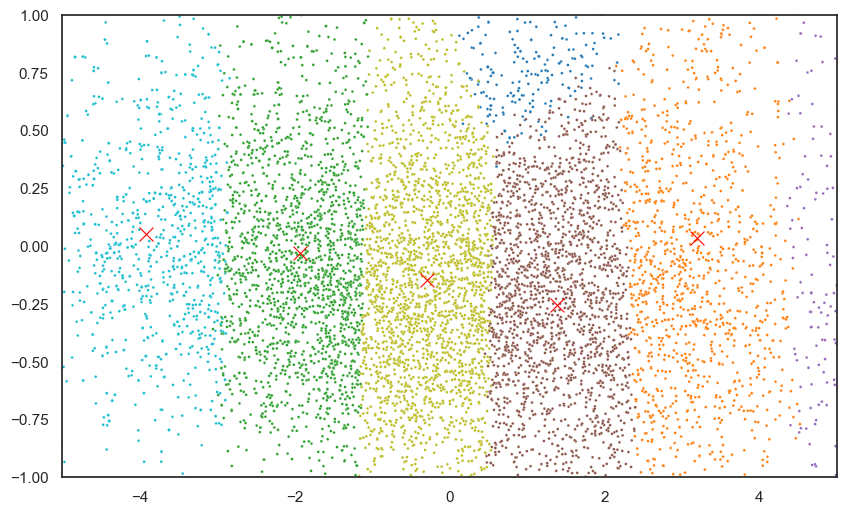

In [77]:
centroids = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=decomposed_data[:,0], y=decomposed_data[:, 1], s=4, c=kmeans.labels_, cmap='tab10',markers='o').set(xlim=(-5, 5), ylim=(-1,1))
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], s=100, color="red", marker="x")

#### Compare metrics with MQM

In [78]:
X = full_metrics.loc[:, normal_columns]
y = full_data.loc[:, 'mqm_avg_score']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

tau score: 0.34678153273466544


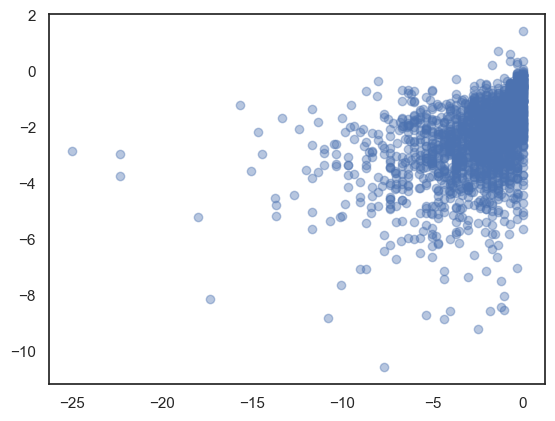

In [115]:
xgb_regressor = xgboost.XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

print(f"tau score: {scipy.stats.kendalltau(y_test, y_pred)[0]}")

plt.scatter(y_test, y_pred, alpha=0.4)